In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys, importlib

In [2]:
repo_path = '/home/simone/repos/IPAM2021_ML/'
sys.path.insert(0, repo_path+'utils/')
import utils as ut
import classyNN as cnn
import errstats as es
import fancyplots as fp

In [3]:
hlayers_sizes   = (50,50)
seed            = 1
verbose_train   = False
epochs          = 100
batch_size      = 128

show_figs       = True
save_figs       = False

out_intervals = [[1,2], [1,2], [0.8,2]]

linear_output  = False # if True, out_intervals is ignored.
compact_scaler = False
std_scaler     = True
sigma0         = 10

## Load data 

In [4]:
data_path = repo_path+'datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'
xtrain = cnn.extract_data(data_path+'xtrain.csv')
ytrain = cnn.extract_data(data_path+'ytrain.csv')
xtest  = cnn.extract_data(data_path+'xtest.csv')
ytest  = cnn.extract_data(data_path+'ytest.csv')

nfeatures = len(xtrain[0,:])
names   = ['m1', 'm2', 'Mc'];

--------------------------------------------------  train  -------------------------------------------------


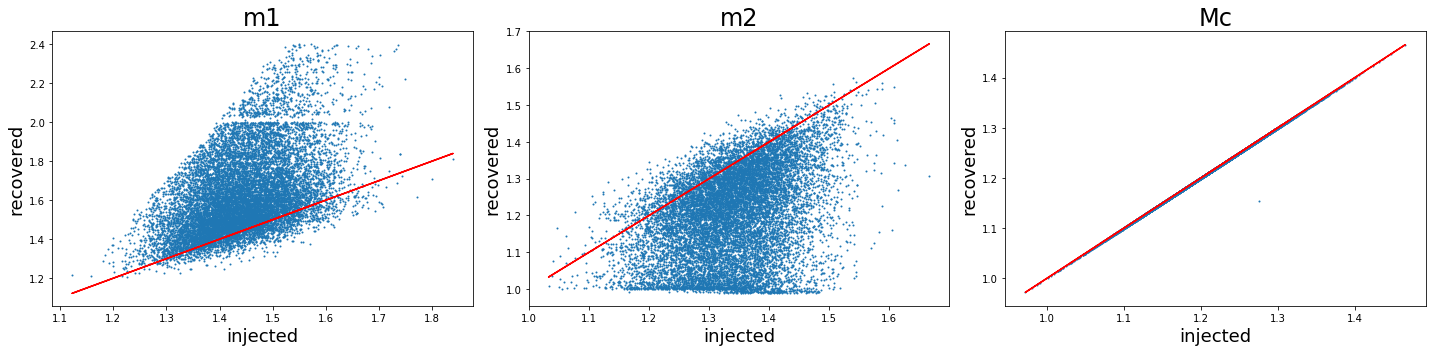

In [5]:
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,5))
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(ytrain[:,i], xtrain[:,i],s=1)
    ax.plot(ytrain[:,i], ytrain[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

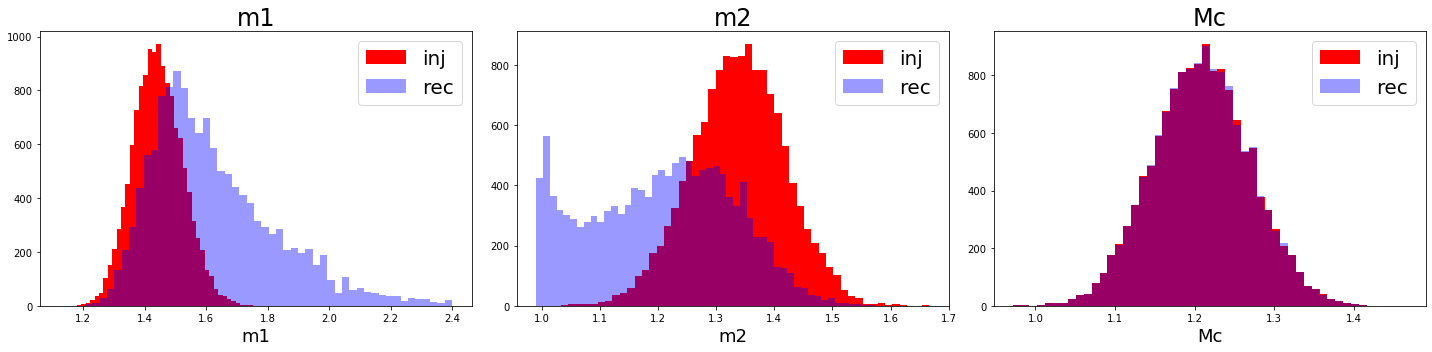

In [6]:
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytrain[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtrain[:,i], bins=50, alpha=0.4, color=[0,0,1], label='rec')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

## Train NN

In [7]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes, out_intervals=out_intervals, 
                      seed=seed, linear_output=linear_output)
NN.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 2,903
Trainable params: 2,903
Non-trainable params: 0
_________________________________________________________________


In [8]:
NN.load_train_dataset(xtrain_data=xtrain, ytrain_data=ytrain, 
                      verbose=False, standard_scaler=std_scaler, sigma0=sigma0, compact_scaler=compact_scaler)

In [9]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train)

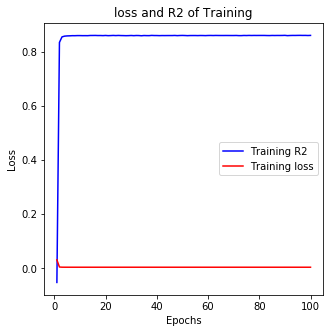

In [10]:
NN.plot_history(show=show_figs, save=save_figs)

## Check prediction

In [11]:
NN.load_test_dataset(xtest_data=xtest, ytest_data=ytest)
NN.print_metrics()

Final R2 mean  : 0.83648
R2[ 0]         : 0.72969
R2[ 1]         : 0.77988
R2[ 2]         : 0.99988


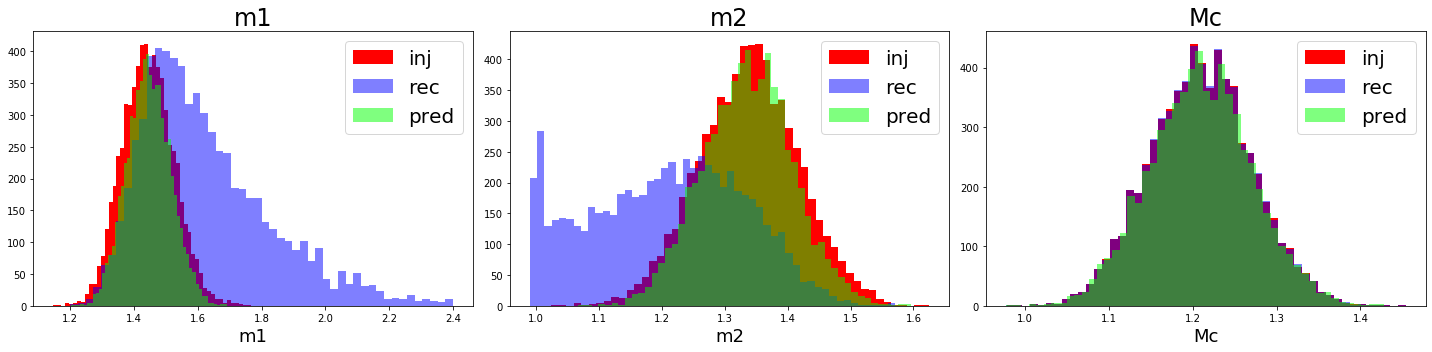

In [12]:
pred = NN.compute_prediction(NN.xtest, transform_output=True) # normalized prediction
plt.figure(figsize=(20,5))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(1,3,i+1)
    ax.hist(ytest[:,i], bins=50, alpha=1,   color=[1,0,0], label='inj')
    ax.hist(xtest[:,i], bins=50, alpha=0.5, color=[0,0,1], label='rec')
    ax.hist( pred[:,i], bins=50, alpha=0.5, color=[0,1,0], label='pred')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr_wpred.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.12493 (std= 0.12255, | rel diff |= 0.13107)
mean pred  rel diff  :  -0.00210 (std= 0.02855, | rel diff |= 0.02322)


median rec   rel diff  :  -0.09535
median pred  rel diff  :  -0.00703


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


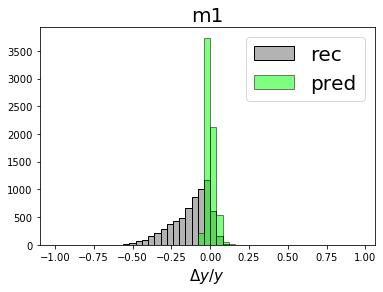

-----------------------------------------------  m2 --------------------------------------------------
mean rec  difference :   0.13106 (std= 0.11887, |difference|= 0.13904)
mean pred difference :   0.00166 (std= 0.03717, |difference|= 0.03015)


median rec  difference :   0.11284
median pred difference :   0.00802


recovery   below fmin= -1.00: 0
recovery   above fmax=  1.00: 0
prediction below fmin= -1.00: 0
prediction above fmax=  1.00: 0


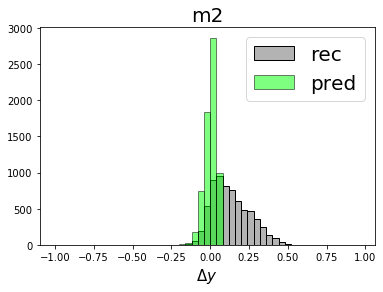

------------------------------------------------ Mc --------------------------------------------------
mean rec  difference :   0.00008 (std= 0.00015, |difference|= 0.00010)
mean pred difference :  -0.00006 (std= 0.00066, |difference|= 0.00044)


median rec  difference :   0.00004
median pred difference :   0.00001


recovery   below fmin= -0.01: 0
recovery   above fmax=  0.01: 0
prediction below fmin= -0.01: 0
prediction above fmax=  0.01: 2


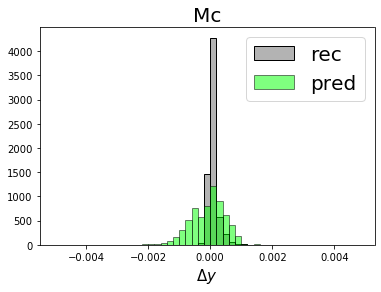

In [13]:
nolatex_names = [ 'm1',   ' m2',    'Mc' ]
fmin_vec      = [   -1,     -1 ,   -0.005]
fmax_vec      = [    1,      1 ,    0.005]
abs_diff_vec  = [False,     True,    True]
logscale_vec  = [False,    False,   False]

for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i], nbins=50)

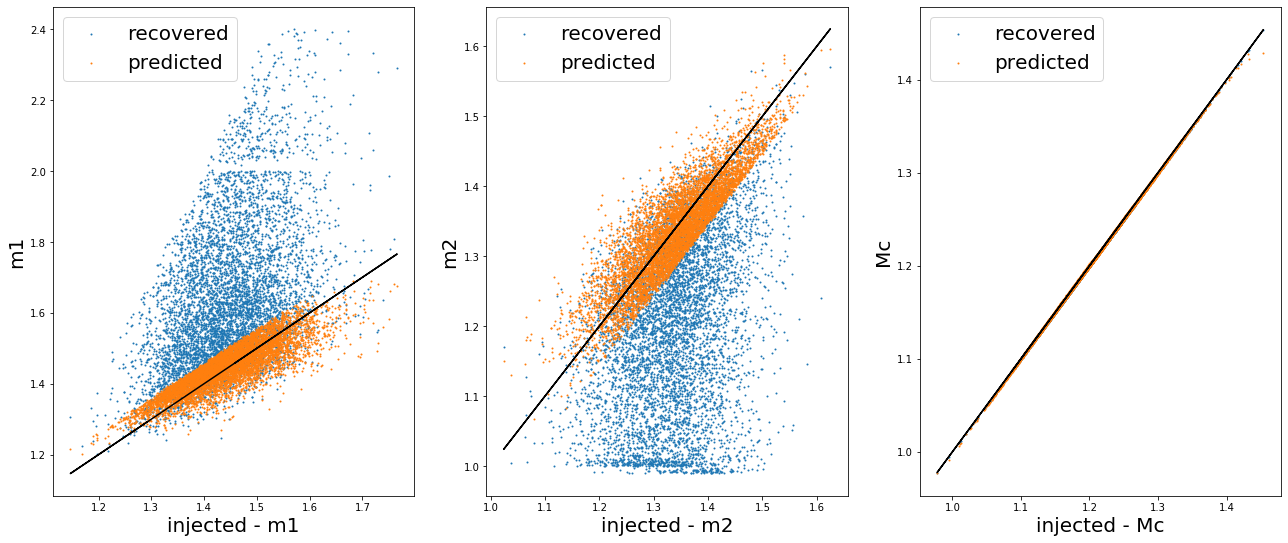

In [14]:
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

## Error stats

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm

####################################################################################################
features n.0: m1
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



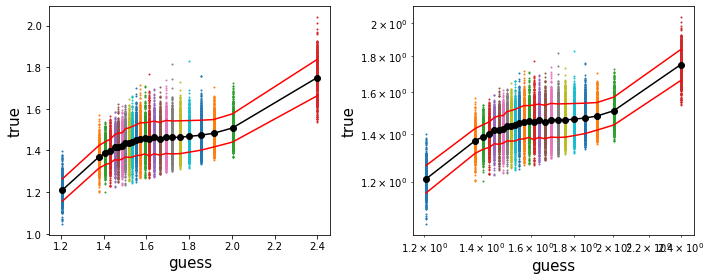

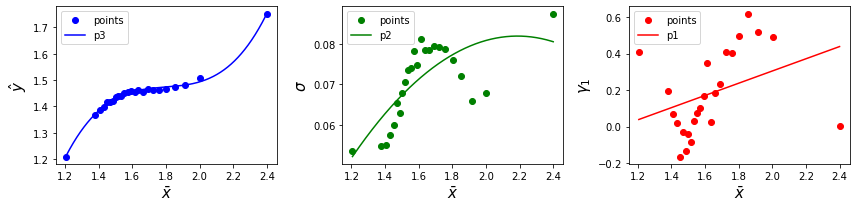

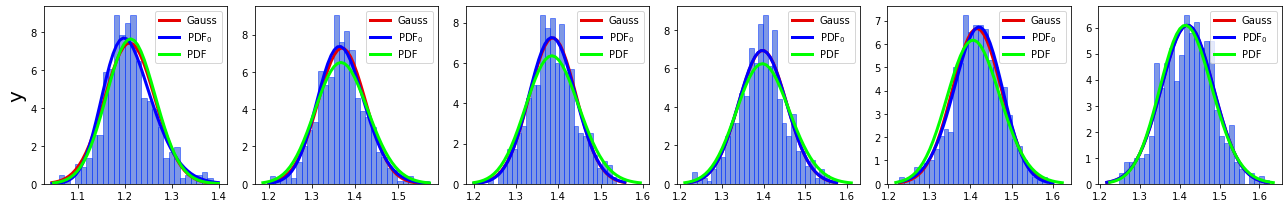

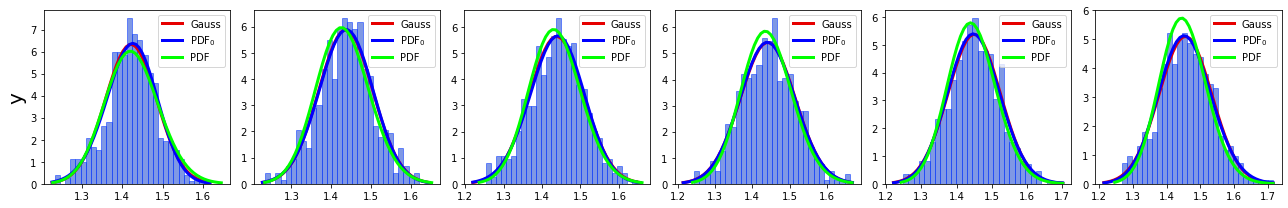

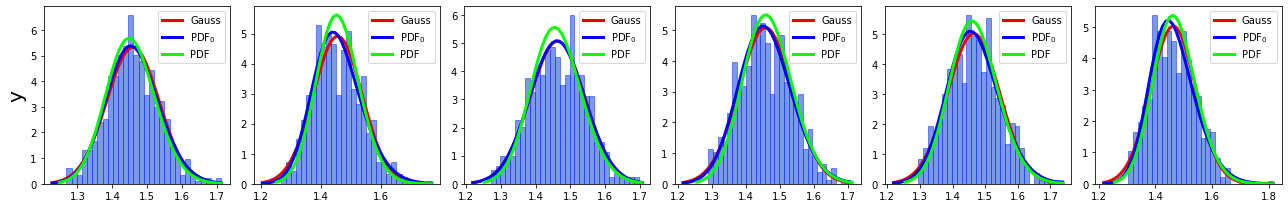

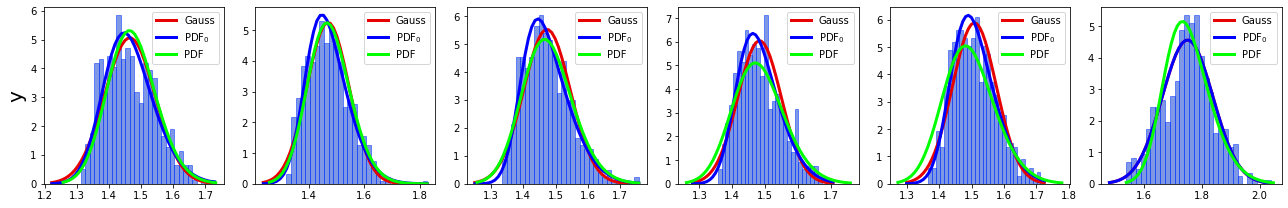

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



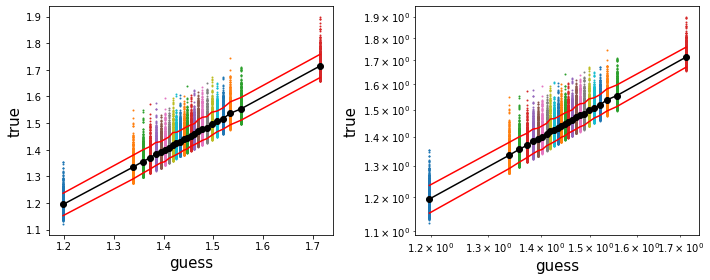

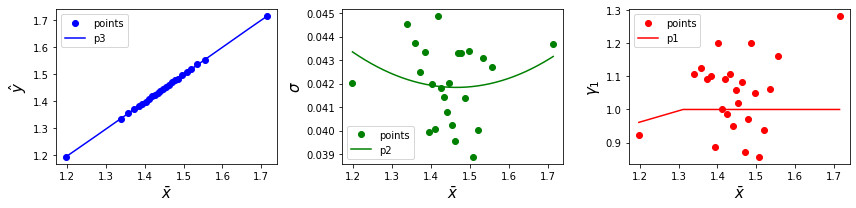

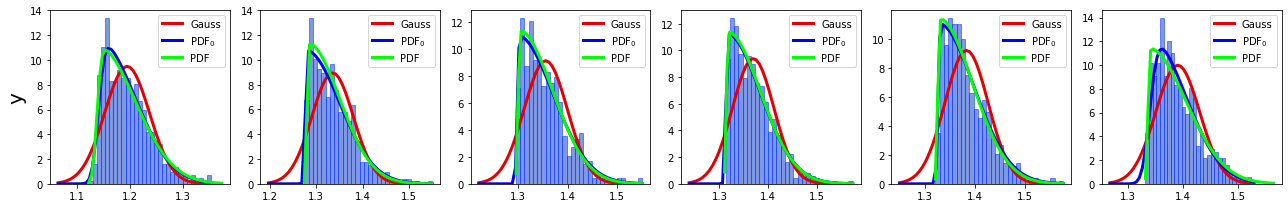

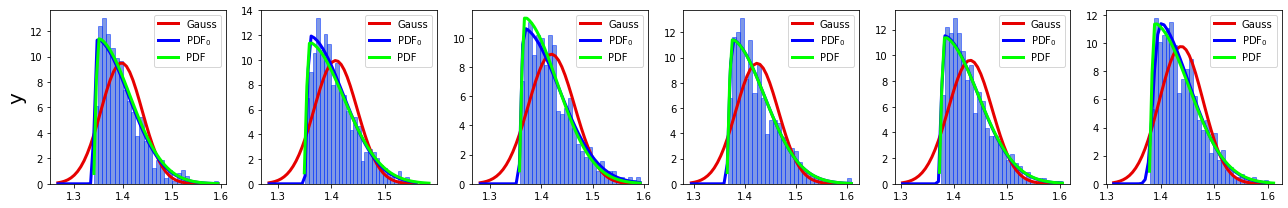

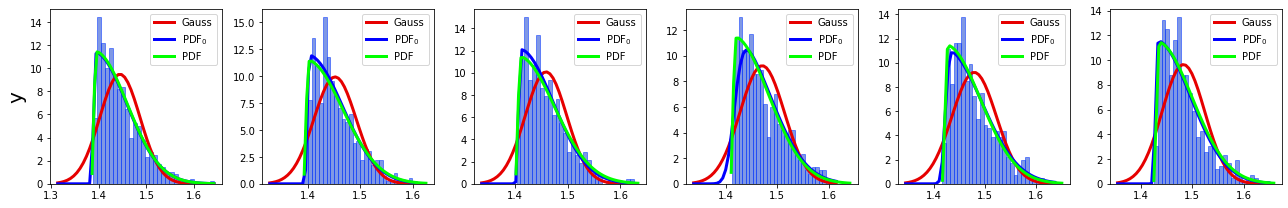

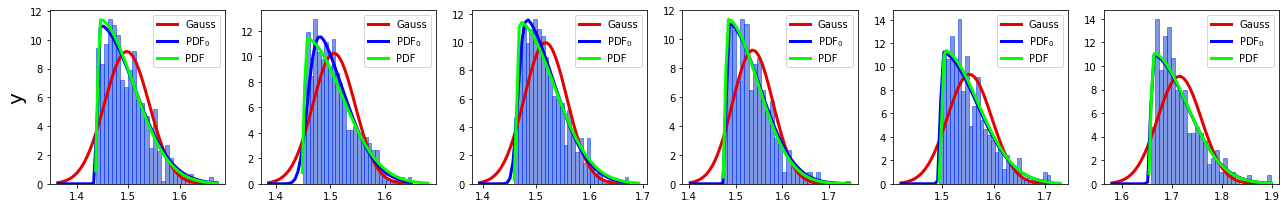

####################################################################################################
features n.1: m2
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



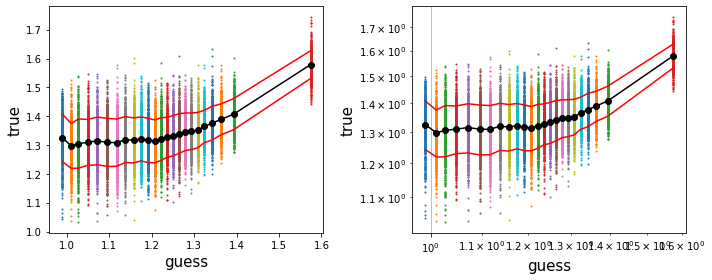

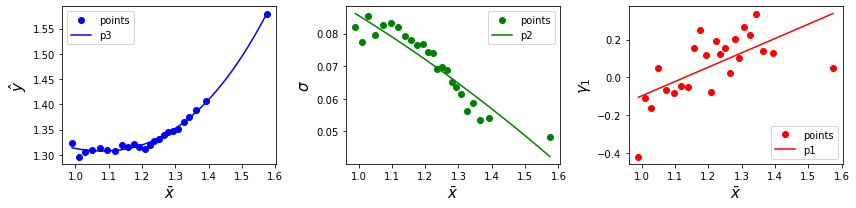

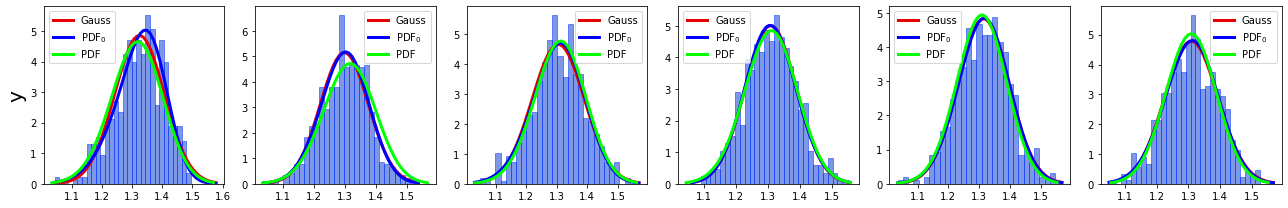

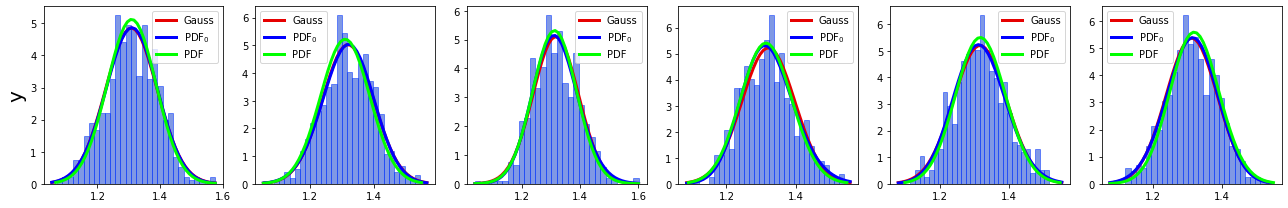

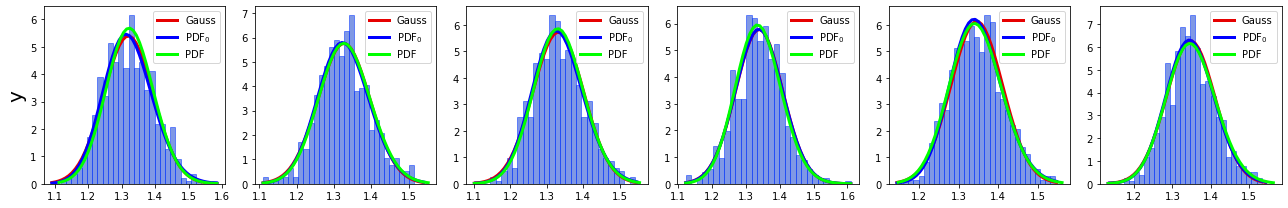

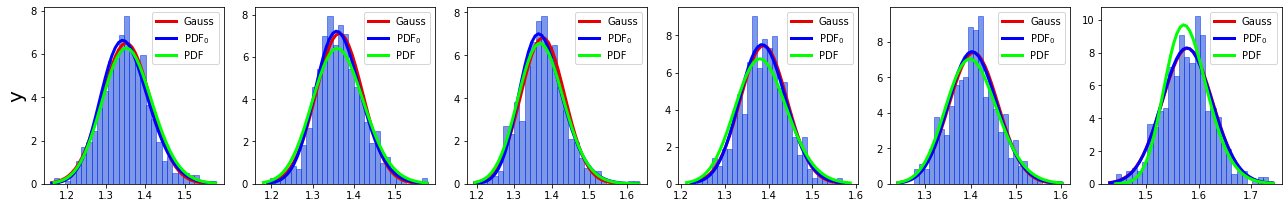

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



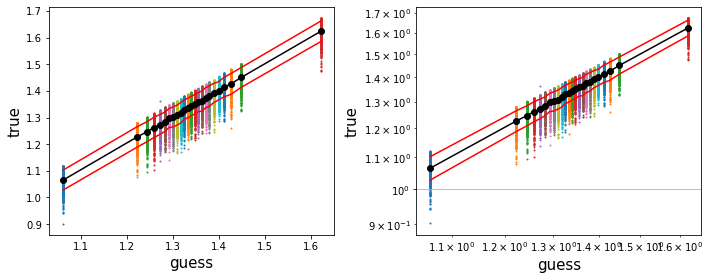

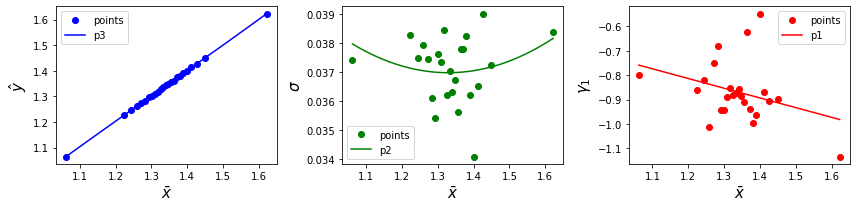

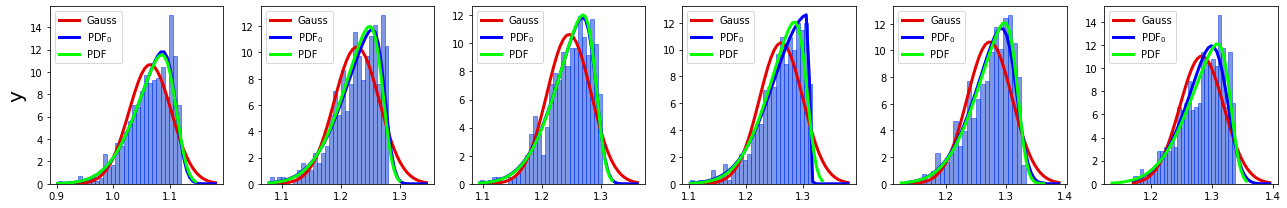

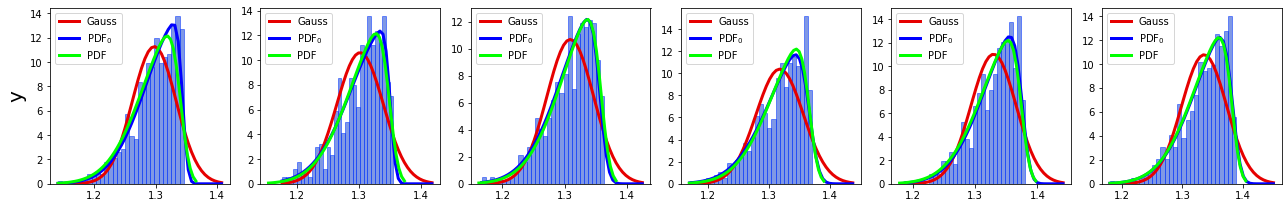

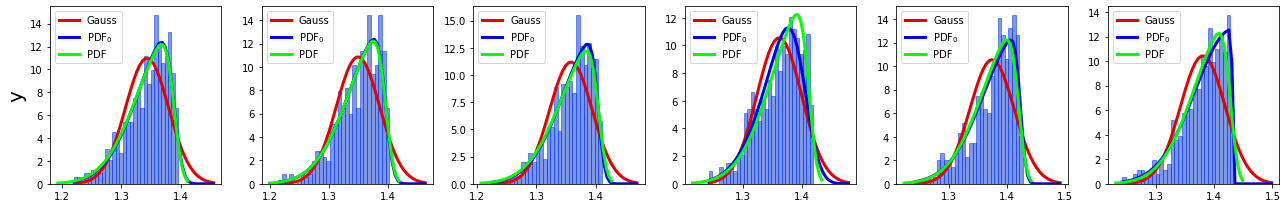

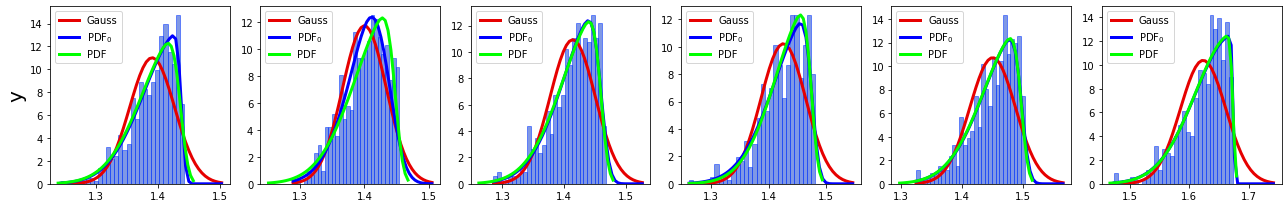

####################################################################################################
features n.2: Mc
####################################################################################################
----------------------------------------------------------------------------------------------------
dset: recovered
----------------------------------------------------------------------------------------------------



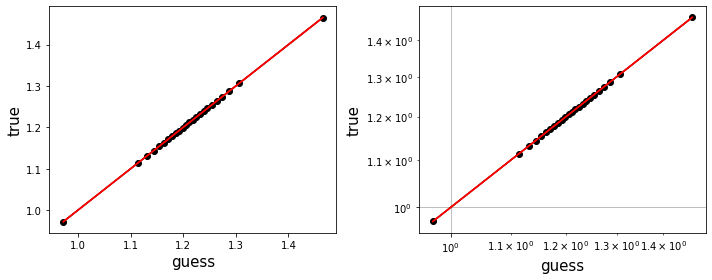

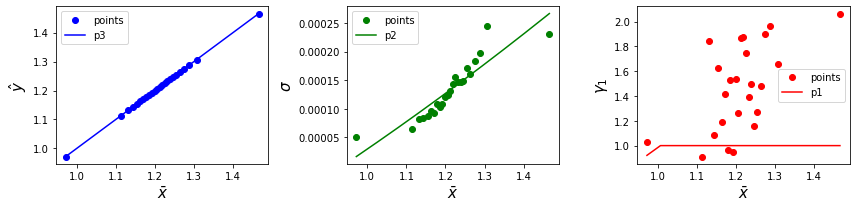

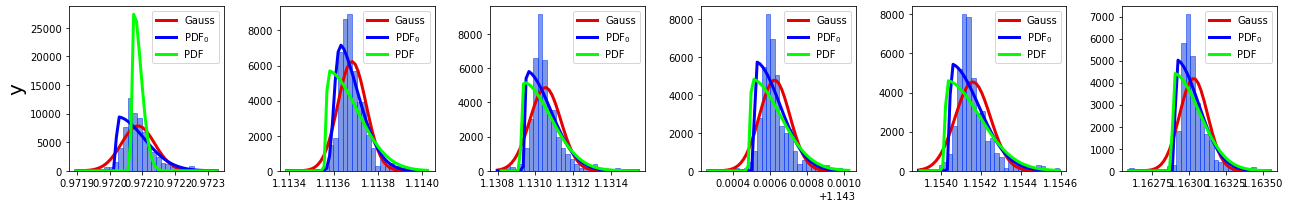

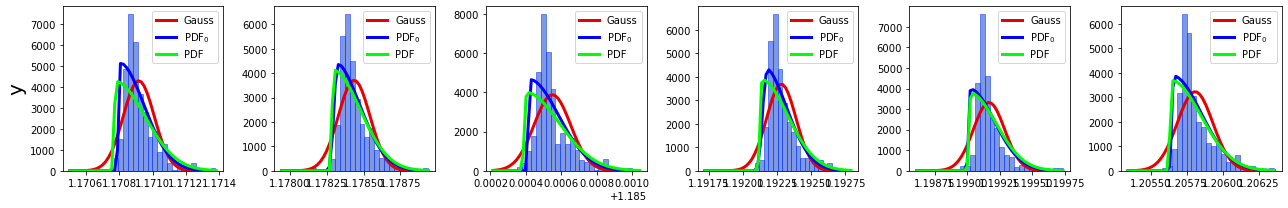

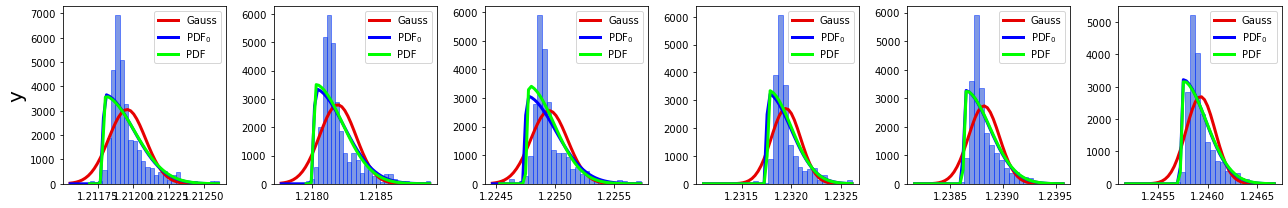

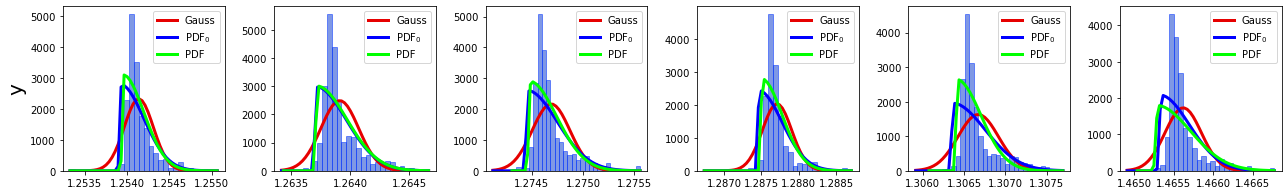

----------------------------------------------------------------------------------------------------
dset: predicted
----------------------------------------------------------------------------------------------------



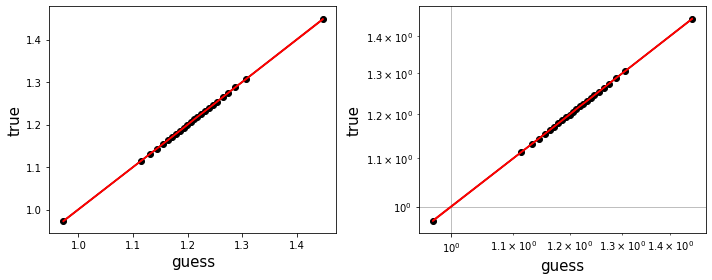

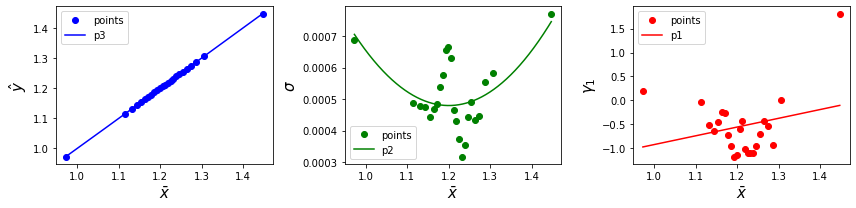

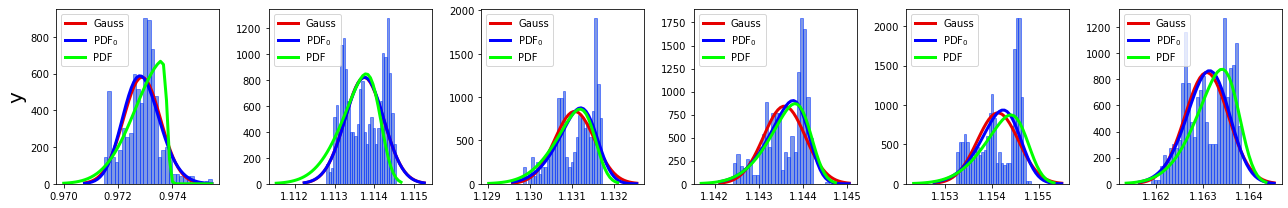

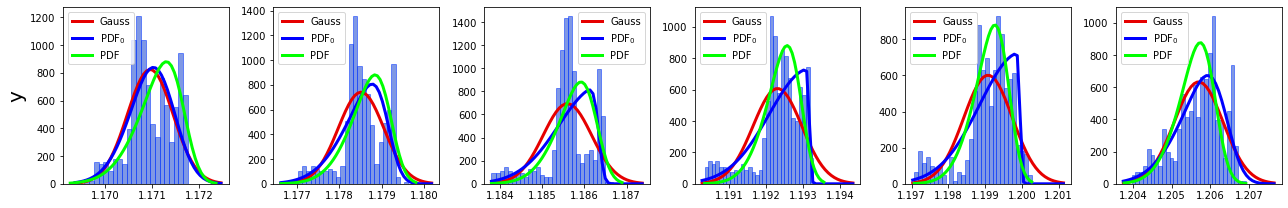

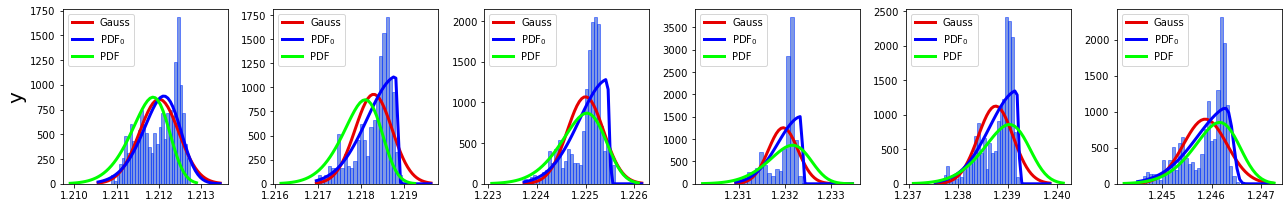

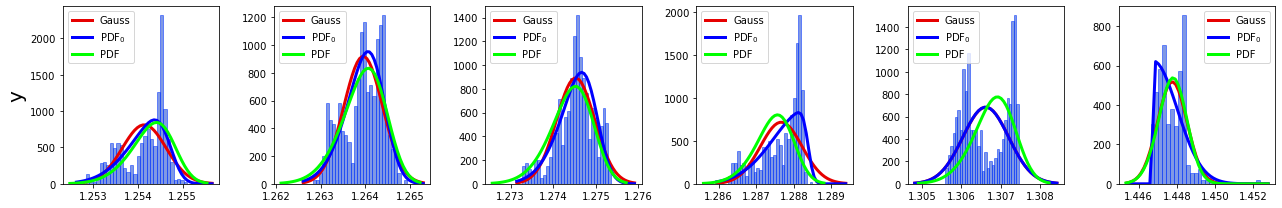

In [19]:
importlib.reload(es)

X = [recovered, predicted]
dsets = ['recovered', 'predicted']

for i in range(nfeatures):
    print('#'*100, '\nfeatures n.', i, ': ', names[i], '\n', '#'*100, sep='')
    for x, dset in zip(X, dsets):
        print('-'*100, '\ndset: ', dset, '\n', '-'*100, sep='', end='\n\n')
        ErrorStats = es.ErrorStats(x[:,i],injected[:,i], n=565, project=True, sigma=5, shift_extrema=True, \
                                  npoly=[3,2,1])        
        ErrorStats.plot_bins()
        #ErrorStats.plot_xstep()
        ErrorStats.plot_moments(plot_poly_fit=True)
        ErrorStats.plot_stats(plot_xbins=False, show_info=False, plot_exact_distr=True, 
                              plot_distr=True, show_gauss=True)